In [ ]:
!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 570.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [ ]:
from torch.utils.data import DataLoader, Subset, random_split

def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    # Initialize an empty list to hold DataLoaders for each node
    dataloaders = []

    # Step 1: Create a DataLoader to load n_samples_per_node from the dataset
    initial_loader = DataLoader(dataset, batch_size=n_samples_per_node*nb_nodes, shuffle=shuffle)
    for initial_batch in initial_loader:
        initial_data, initial_labels = initial_batch
        break  # We only need the first batch

    # Step 2: Split the data into nb_nodes i.i.d subsets
    # Calculate the length of each split
    lengths = [n_samples_per_node for _ in range(nb_nodes)]

    # Randomly split dataset into nb_nodes i.i.d. subsets
    subsets = random_split(range(n_samples_per_node*nb_nodes), lengths)

    for i in range(nb_nodes):
        # Create a Subset object for each node
        subset_data = Subset(dataset, subsets[i].indices)

        # Create a DataLoader object for each Subset
        dataloader = DataLoader(subset_data, batch_size=batch_size, shuffle=shuffle)

        # Append the DataLoader to the list
        dataloaders.append(dataloader)

    # Step 3: Return the list of DataLoaders
    return dataloaders

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [ ]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    #### TO DO ####
    digits_per_node = np.array_split(digits, nb_nodes)

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes * n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=[]
    for i in range(nb_nodes):
        # Get indices for the digits
        indices = [j for j, label in enumerate(labels_train_mnist) if label.item() in digits_per_node[i]]

        # Create Subset and DataLoader for this node
        subset_data = Subset(dataset, indices)
        node_dataloader = DataLoader(subset_data, batch_size=batch_size, shuffle=shuffle)

        # Append the DataLoader to the list
        data_splitted.append(node_dataloader)
    # return data_splitted with all data loaders
    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [ ]:
from torchvision import datasets, transforms

def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

    # Step 2: Apply Split Function
    if type == "iid":
        train_dataloaders = iid_split(mnist_train, n_clients, n_samples_train, batch_size, shuffle)
        test_dataloaders = iid_split(mnist_test, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_dataloaders = non_iid_split(mnist_train, n_clients, n_samples_train, batch_size, shuffle)
        test_dataloaders = non_iid_split(mnist_test, n_clients, n_samples_test, batch_size, shuffle)
    else:
        raise ValueError("Invalid type specified. Choose either 'iid' or 'non_iid'.")

    # Step 3: Return DataLoaders
    return train_dataloaders, test_dataloaders

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [ ]:
mnist_iid_train, mnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 93880032.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41132663.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23244818.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7901505.09it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [ ]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

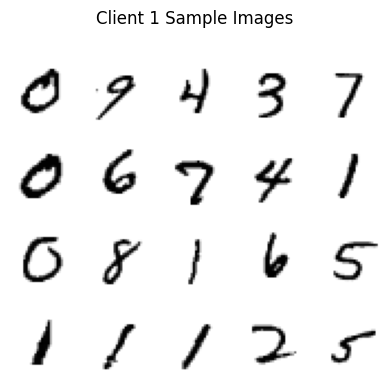

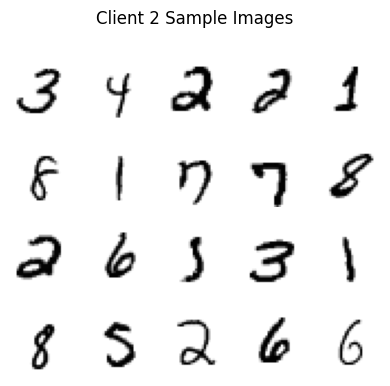

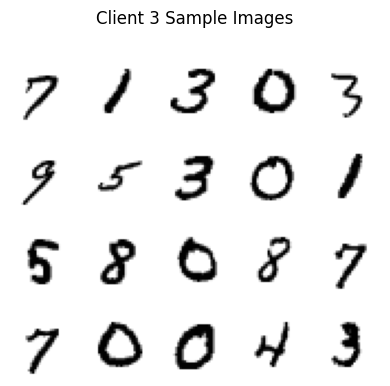

In [ ]:
for i, client_dataloader in enumerate(mnist_iid_train[:3]):
    images, labels = next(iter(client_dataloader))
    plot_samples((images, labels), channel=0, title=f"Client {i+1} Sample Images")

6) Plot samples this time for non_iid data for 3 clients.

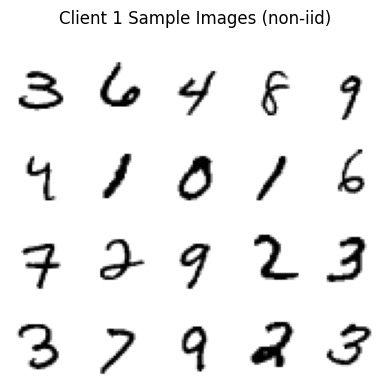

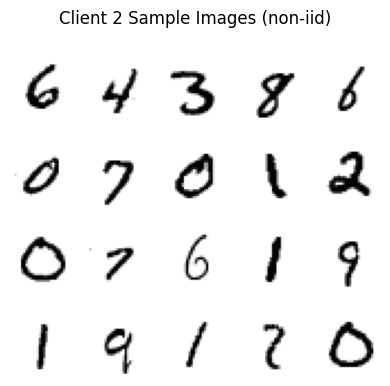

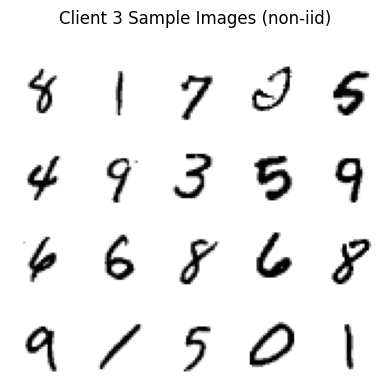

In [ ]:
mnist_noniid_train, mnist_noniid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

# Plot samples for client 1, 2, and 3
for i, client_dataloader in enumerate(mnist_noniid_train[:3]):
    images, labels = next(iter(client_dataloader))
    plot_samples((images, labels), channel=0, title=f"Client {i+1} Sample Images (non-iid)")

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [ ]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [ ]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    diff = 0.0

    for p1, p2 in zip(model_1.parameters(), model_2.parameters()):
        diff += torch.sum((p1 - p2) ** 2).item()

    return diff

Here is the function to perform one epoch of training data.

In [ ]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [ ]:
import copy

def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    model_0 = copy.deepcopy(model)

    # Initialize local_loss variable
    local_loss = 0.0

    for epoch in range(epochs):
        # Perform one epoch of training and store the average loss
        local_loss = train_step(model, model_0, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [ ]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [ ]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [ ]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model=deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer=optim.SGD(local_model.parameters(), lr=lr)
            # compute local_loss by performing learning steps on the current model
            train_data = training_sets[k]
            local_loss = local_learning(local_model, mu, local_optimizer, train_data, epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=[tens_param.detach() for tens_param in list(local_model.parameters())]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [ ]:
final_model, loss_hist, acc_hist = FedProx(model_0, training_sets=mnist_iid_train, n_iter=20, testing_sets=mnist_iid_test, mu=0, epochs=5, lr=0.01)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.298946936925252 Server Test Accuracy: 9.0
====> i: 1 Loss: 2.2770206928253174 Server Test Accuracy: 28.999999999999996
====> i: 2 Loss: 2.24968942006429 Server Test Accuracy: 32.666666666666664
====> i: 3 Loss: 2.2070480982462564 Server Test Accuracy: 37.666666666666664
====> i: 4 Loss: 2.1275823911031084 Server Test Accuracy: 47.33333333333333
====> i: 5 Loss: 1.95977512995402 Server Test Accuracy: 56.0
====> i: 6 Loss: 1.6028228600819905 Server Test Accuracy: 62.666666666666664
====> i: 7 Loss: 1.120161215464274 Server Test Accuracy: 70.33333333333333
====> i: 8 Loss: 0.7891204555829365 Server Test Accuracy: 76.66666666666666
====> i: 9 Loss: 0.615086555480957 Server Test Accuracy: 77.66666666666666
====> i: 10 Loss: 0.52032071352005 Server Test Accuracy: 79.33333333333333
====> i: 11 Loss: 0.4520014822483062 Server Test Accuracy: 82.33333333333333
====> i: 12 Loss: 0.4272096753120422 Se

2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

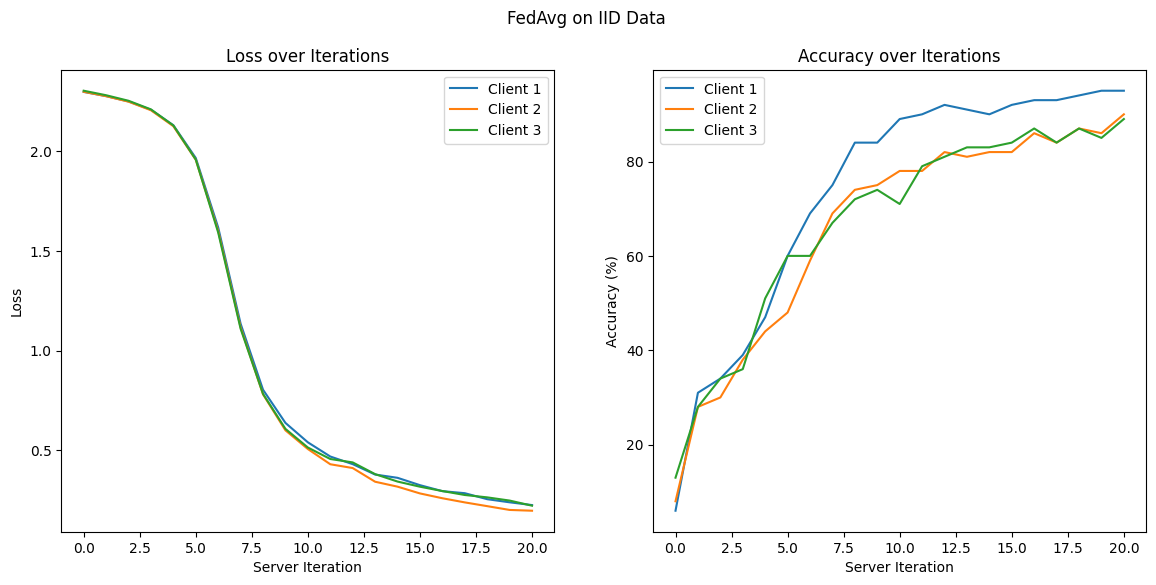

In [ ]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    n_iter = len(loss_hist)

    # Create figure and axis objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot loss
    for client_idx in range(len(loss_hist[0])):
        loss_for_client = [loss_hist[i][client_idx] for i in range(n_iter)]
        ax1.plot(range(n_iter), loss_for_client, label=f"Client {client_idx + 1}")

    ax1.set_title("Loss over Iterations")
    ax1.set_xlabel("Server Iteration")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot accuracy
    for client_idx in range(len(acc_hist[0])):
        acc_for_client = [acc_hist[i][client_idx] for i in range(n_iter)]
        ax2.plot(range(n_iter), acc_for_client, label=f"Client {client_idx + 1}")

    ax2.set_title("Accuracy over Iterations")
    ax2.set_xlabel("Server Iteration")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()

    # Overall title
    plt.suptitle(title)

    # Show the plots
    plt.show()

plot_acc_loss("FedAvg on IID Data", loss_hist, acc_hist)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [ ]:
final_model_p, loss_hist_p, acc_hist_p = FedProx(
    model=model_0,
    training_sets=mnist_iid_train,
    n_iter=10,
    testing_sets=mnist_iid_test,
    mu=0.3,
    epochs=2,
    lr=0.1
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.2978293895721436 Server Test Accuracy: 11.333333333333332
====> i: 1 Loss: 2.2364884217580157 Server Test Accuracy: 38.0
====> i: 2 Loss: 1.8694631656010945 Server Test Accuracy: 49.33333333333333
====> i: 3 Loss: 0.9690579175949096 Server Test Accuracy: 67.66666666666666
====> i: 4 Loss: 0.5978543162345886 Server Test Accuracy: 72.33333333333333
====> i: 5 Loss: 0.40885284543037415 Server Test Accuracy: 80.66666666666666
====> i: 6 Loss: 0.33345236380894977 Server Test Accuracy: 85.33333333333333
====> i: 7 Loss: 0.254698505004247 Server Test Accuracy: 89.66666666666666
====> i: 8 Loss: 0.18854859968026477 Server Test Accuracy: 90.33333333333333
====> i: 9 Loss: 0.13949461032946903 Server Test Accuracy: 91.0
====> i: 10 Loss: 0.1140787328282992 Server Test Accuracy: 90.0


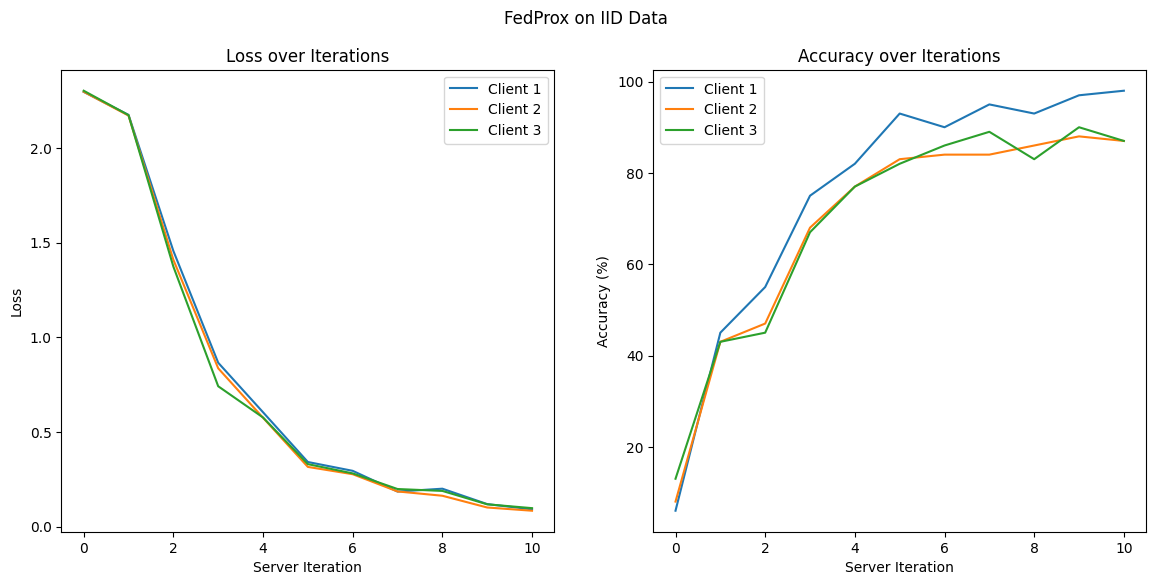

In [ ]:
plot_acc_loss("FedProx on IID Data", loss_hist_p, acc_hist_p)

4) What do you observe ?

On remarque que la loss du modèle obtenue par FedProx est largement plus petit que celui du modèle de FedAvg pour une accuracy assez similaire.

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

In [ ]:
final_model, loss_hist, acc_hist = FedProx(
    model=model_0,
    training_sets=mnist_noniid_train,
    n_iter=20,
    testing_sets=mnist_noniid_test,
    mu=0,
    epochs=5,
    lr=0.1
)

Clients' weights: [0.4033333333333333, 0.2816666666666667, 0.315]
====> i: 0 Loss: 2.298592921098073 Server Test Accuracy: 8.932700421940929
====> i: 1 Loss: 0.8885495728254318 Server Test Accuracy: 67.96495780590718
====> i: 2 Loss: 0.37322770968079566 Server Test Accuracy: 83.37139240506329
====> i: 3 Loss: 0.19142915380497777 Server Test Accuracy: 88.31755274261603
====> i: 4 Loss: 0.11035480966170629 Server Test Accuracy: 92.05871308016877
====> i: 5 Loss: 0.07556037656962872 Server Test Accuracy: 93.3920464135021
====> i: 6 Loss: 0.05911370154470205 Server Test Accuracy: 93.3920464135021
====> i: 7 Loss: 0.04015164982527494 Server Test Accuracy: 93.74858649789029
====> i: 8 Loss: 0.028760134919236104 Server Test Accuracy: 93.41525316455696
====> i: 9 Loss: 0.020877639455720784 Server Test Accuracy: 94.08191983122363
====> i: 10 Loss: 0.016743849668030938 Server Test Accuracy: 94.37371308016877
====> i: 11 Loss: 0.01377747269657751 Server Test Accuracy: 94.37371308016877
====> i: 1

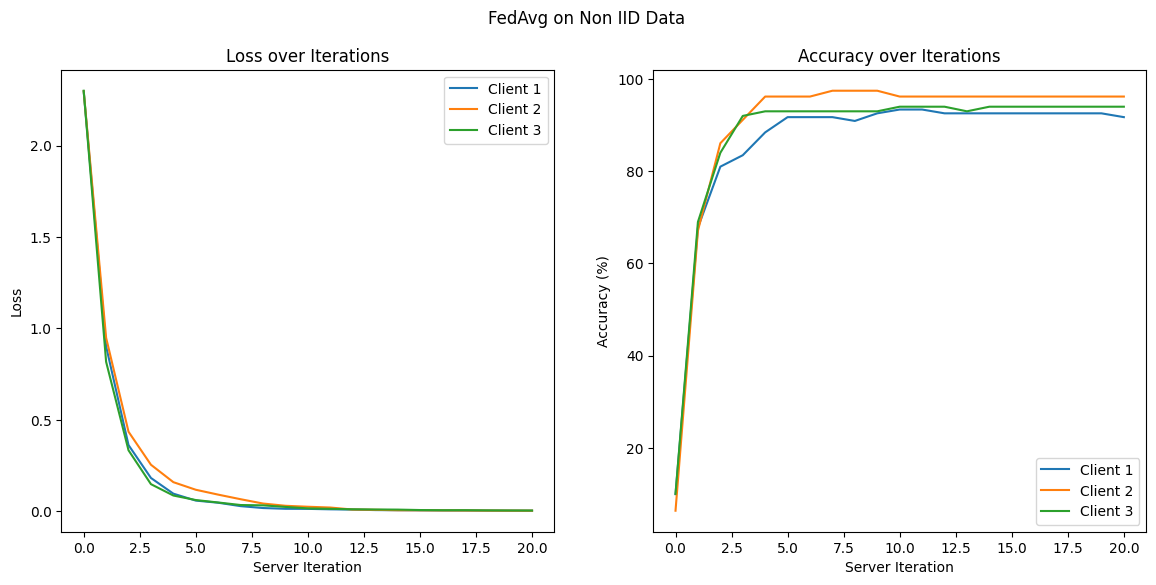

In [ ]:
plot_acc_loss("FedAvg on Non IID Data", loss_hist, acc_hist)

In [ ]:
final_model_p, loss_hist_p, acc_hist_p = FedProx(
    model=model_0,
    training_sets=mnist_noniid_train,
    n_iter=10,
    testing_sets=mnist_noniid_test,
    mu=0.3,
    epochs=2,
    lr=0.1
)

Clients' weights: [0.4033333333333333, 0.2816666666666667, 0.315]
====> i: 0 Loss: 2.299032059510549 Server Test Accuracy: 8.932700421940929
====> i: 1 Loss: 2.158892869949341 Server Test Accuracy: 43.533143459915614
====> i: 2 Loss: 1.2007958422104519 Server Test Accuracy: 69.25303797468354
====> i: 3 Loss: 0.7297924768924713 Server Test Accuracy: 74.70240506329114
====> i: 4 Loss: 0.4398478193581104 Server Test Accuracy: 80.31035864978904
====> i: 5 Loss: 0.3623938483993212 Server Test Accuracy: 84.6313924050633
====> i: 6 Loss: 0.24857880589862666 Server Test Accuracy: 87.07101265822784
====> i: 7 Loss: 0.19817850674192108 Server Test Accuracy: 89.75717299578059
====> i: 8 Loss: 0.14029970501859984 Server Test Accuracy: 91.06729957805908
====> i: 9 Loss: 0.10827258422970773 Server Test Accuracy: 92.70217299578059
====> i: 10 Loss: 0.09670513891925414 Server Test Accuracy: 94.4335864978903


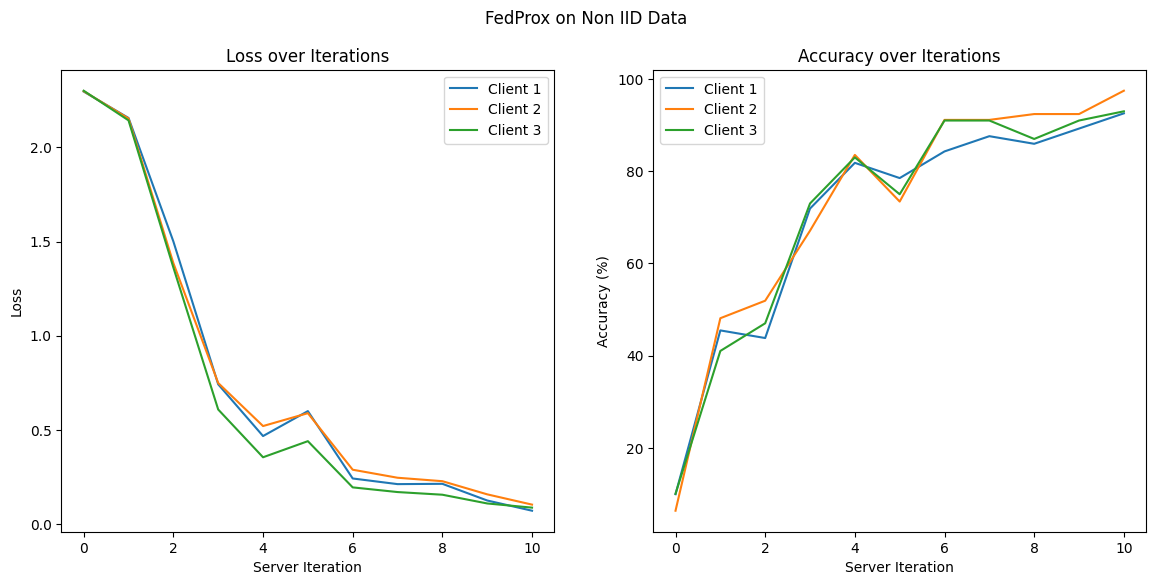

In [ ]:
plot_acc_loss("FedProx on Non IID Data", loss_hist_p, acc_hist_p)

2) What do you observe ?

On remarque qu'avec FedAvg le modèle atteint une accuracy très élevé au début tandis que le modèle FedProx commence plus bas. Au final, le résulat FedProx donne une une meilleur accuracy sur les tests parce que FedAvg a overfit à la fin.

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [ ]:
! pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=e29868c0aabc5544d0499d7f73523af2dc5af5e7884bb214e383cbcd6118edac
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Import medmnist

In [ ]:
import medmnist

You can list all available datasets with this command

In [ ]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [ ]:
from medmnist import BloodMNIST

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [ ]:
# Define a preprocessing pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [ ]:
blood_mnist_train = BloodMNIST(root='.', split='train', transform=transform)
blood_mnist_test = BloodMNIST(root='.', split='test', transform=transform)

4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

In [ ]:
# Get one sample from the training dataset
train_sample_data, train_sample_label = blood_mnist_train[0]
print("Train sample data shape:", train_sample_data.shape)
print("Train sample label:", train_sample_label)

# Get one sample from the test dataset
test_sample_data, test_sample_label = blood_mnist_test[0]
print("Test sample data shape:", test_sample_data.shape)
print("Test sample label:", test_sample_label)

Train sample data shape: torch.Size([3, 28, 28])
Train sample label: [7]
Test sample data shape: torch.Size([3, 28, 28])
Test sample label: [3]


5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [ ]:
train_loader = DataLoader(blood_mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(blood_mnist_test, batch_size=128, shuffle=False)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [ ]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=8)

    digits=torch.arange(8) if shuffle_digits==False else torch.randperm(8, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    #### TO DO ####
    digits_per_node = np.array_split(digits, nb_nodes)

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes * n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=[]
    for i in range(nb_nodes):
        # Get indices for the digits
        indices = [j for j, label in enumerate(labels_train_mnist) if label.item() in digits_per_node[i]]

        # Create Subset and DataLoader for this node
        subset_data = Subset(dataset, indices)
        node_dataloader = DataLoader(subset_data, batch_size=batch_size, shuffle=shuffle)

        # Append the DataLoader to the list
        data_splitted.append(node_dataloader)
    # return data_splitted with all data loaders
    return data_splitted



In [ ]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
    ])
    blood_mnist_train = BloodMNIST(root='./data', split='train', download=True, transform=transform)
    blood_mnist_test = BloodMNIST(root='./data', split='test', download=True, transform=transform)

    # Step 2: Apply Split Function
    if type == "iid":
        train_dataloaders = iid_split(blood_mnist_train, n_clients, n_samples_train, batch_size, shuffle)
        test_dataloaders = iid_split(blood_mnist_test, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_dataloaders = non_iid_split(blood_mnist_train, n_clients, n_samples_train, batch_size, shuffle)
        test_dataloaders = non_iid_split(blood_mnist_test, n_clients, n_samples_test, batch_size, shuffle)
    else:
        raise ValueError("Invalid type specified. Choose either 'iid' or 'non_iid'.")

    # Step 3: Return DataLoaders
    return train_dataloaders, test_dataloaders

In [ ]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")
        ax.set_title(str(y[idx].item()))

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [ ]:
blood_mnist_iid_train, blood_mnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

100%|██████████| 35461855/35461855 [01:06<00:00, 534674.73it/s]


Using downloaded and verified file: ./data/bloodmnist.npz


2. plost samples with corresponding function.

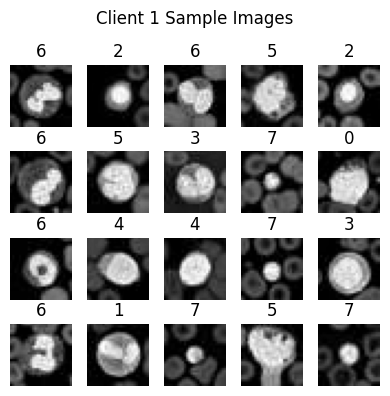

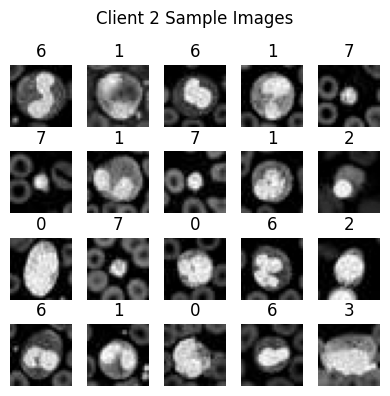

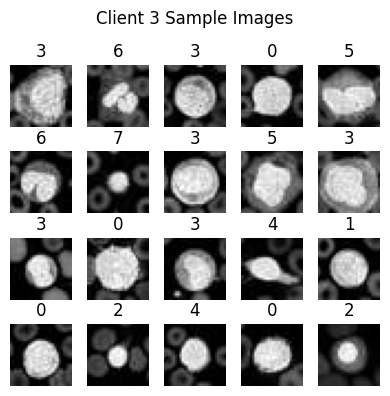

In [ ]:
for i, client_dataloader in enumerate(blood_mnist_iid_train[:3]):
    images, labels = next(iter(client_dataloader))
    plot_samples((images, labels), channel=0, title=f"Client {i+1} Sample Images")

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [ ]:
import torch.nn.functional as F

class MedicalCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(MedicalCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # Block 2
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Block 4
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Block 5
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, padding=1)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Create the model
model = MedicalCNN(num_classes=8)

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [ ]:
final_model, loss_hist, acc_hist = FedProx(model, training_sets=blood_mnist_iid_train, n_iter=20, testing_sets=blood_mnist_iid_test, mu=0, epochs=5, lr=0.01)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.233987728754679 Server Test Accuracy: 9.333333333333332
====> i: 1 Loss: 0.8710364500681559 Server Test Accuracy: 66.0
====> i: 2 Loss: 0.6064401666323344 Server Test Accuracy: 74.66666666666666
====> i: 3 Loss: 0.37145840128262836 Server Test Accuracy: 81.66666666666666
====> i: 4 Loss: 0.2653208076953888 Server Test Accuracy: 79.66666666666666
====> i: 5 Loss: 0.18976960579554236 Server Test Accuracy: 81.66666666666666
====> i: 6 Loss: 0.14160490036010742 Server Test Accuracy: 80.33333333333333
====> i: 7 Loss: 0.11607870459556578 Server Test Accuracy: 80.0
====> i: 8 Loss: 0.09345363328854242 Server Test Accuracy: 81.0
====> i: 9 Loss: 0.07453483094771703 Server Test Accuracy: 79.66666666666666
====> i: 10 Loss: 0.057026077061891556 Server Test Accuracy: 82.33333333333333
====> i: 11 Loss: 0.049056159953276314 Server Test Accuracy: 82.66666666666666
====> i: 12 Loss: 0.04129252272347609

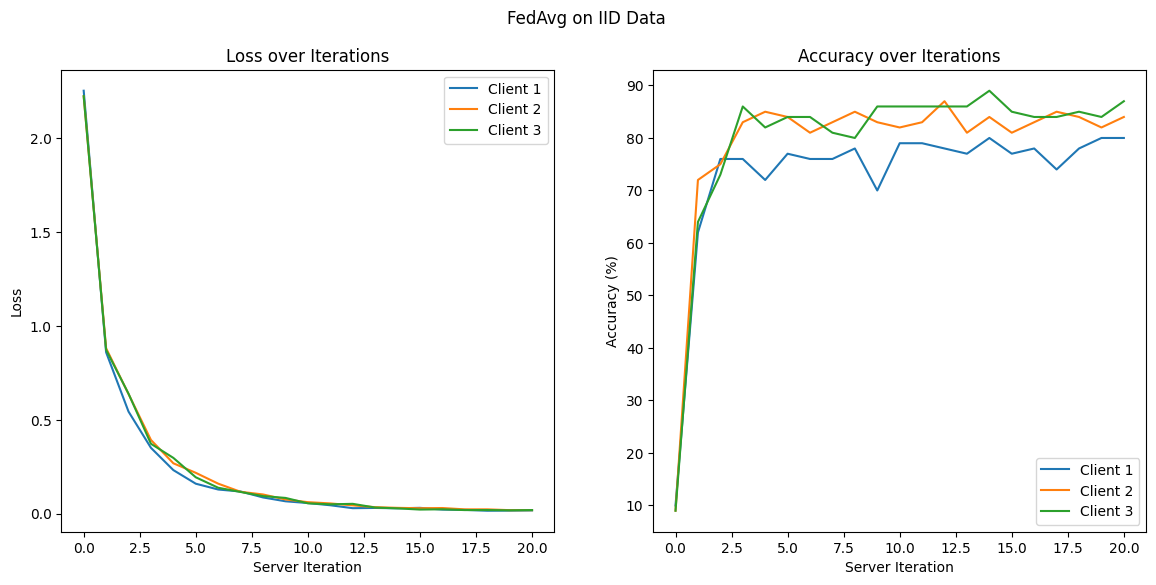

In [ ]:
plot_acc_loss("FedAvg on IID Data", loss_hist, acc_hist)

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

In [ ]:
final_model_p, loss_hist_p, acc_hist_p = FedProx(
    model=model,
    training_sets=blood_mnist_iid_train,
    n_iter=10,
    testing_sets=blood_mnist_iid_test,
    mu=0.3,
    epochs=2,
    lr=0.1
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.2209126154581704 Server Test Accuracy: 9.333333333333332
====> i: 1 Loss: 2.122515519460042 Server Test Accuracy: 12.666666666666664
====> i: 2 Loss: 1.8575570980707803 Server Test Accuracy: 31.666666666666664
====> i: 3 Loss: 1.8023942311604817 Server Test Accuracy: 33.33333333333333
====> i: 4 Loss: 1.8760549227396646 Server Test Accuracy: 27.33333333333333
====> i: 5 Loss: 1.5299347241719563 Server Test Accuracy: 47.0
====> i: 6 Loss: 1.3212891419728596 Server Test Accuracy: 50.0
====> i: 7 Loss: 1.3636310497919717 Server Test Accuracy: 45.666666666666664
====> i: 8 Loss: 1.1864677667617798 Server Test Accuracy: 47.666666666666664
====> i: 9 Loss: 1.1116326649983723 Server Test Accuracy: 54.666666666666664
====> i: 10 Loss: 1.2217455307642617 Server Test Accuracy: 51.33333333333333


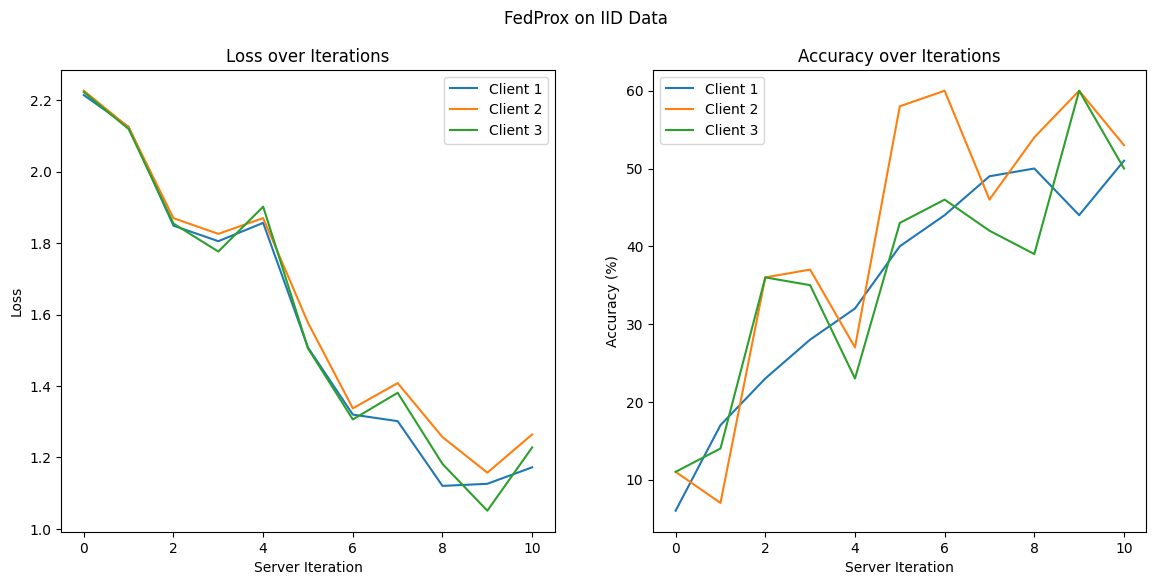

In [ ]:
plot_acc_loss("FedProx on IID Data", loss_hist_p, acc_hist_p)

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

In [ ]:
blood_mnist_noniid_train, blood_mnist_noniid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


In [ ]:
final_model, loss_hist, acc_hist = FedProx(model, training_sets=blood_mnist_noniid_train, n_iter=20, testing_sets=blood_mnist_noniid_test, mu=0, epochs=5, lr=0.01)

Clients' weights: [0.3383333333333333, 0.315, 0.3466666666666667]
====> i: 0 Loss: 2.194029876391093 Server Test Accuracy: 8.009310897435897
====> i: 1 Loss: 0.9628578923145931 Server Test Accuracy: 59.36621794871795
====> i: 2 Loss: 0.5529647949337959 Server Test Accuracy: 75.74615384615385
====> i: 3 Loss: 0.3852453759809335 Server Test Accuracy: 77.07158653846153
====> i: 4 Loss: 0.3449148294329643 Server Test Accuracy: 73.05259615384615
====> i: 5 Loss: 0.2947103069225947 Server Test Accuracy: 76.85019230769231
====> i: 6 Loss: 0.18587581959863503 Server Test Accuracy: 79.38419871794872
====> i: 7 Loss: 0.20448491372168065 Server Test Accuracy: 77.75198717948717
====> i: 8 Loss: 0.1584075351059437 Server Test Accuracy: 81.46139423076923
====> i: 9 Loss: 0.10225056383758782 Server Test Accuracy: 82.46711538461538
====> i: 10 Loss: 0.07671851852287849 Server Test Accuracy: 80.39552884615384
====> i: 11 Loss: 0.05774781014149388 Server Test Accuracy: 84.1049358974359
====> i: 12 Loss:

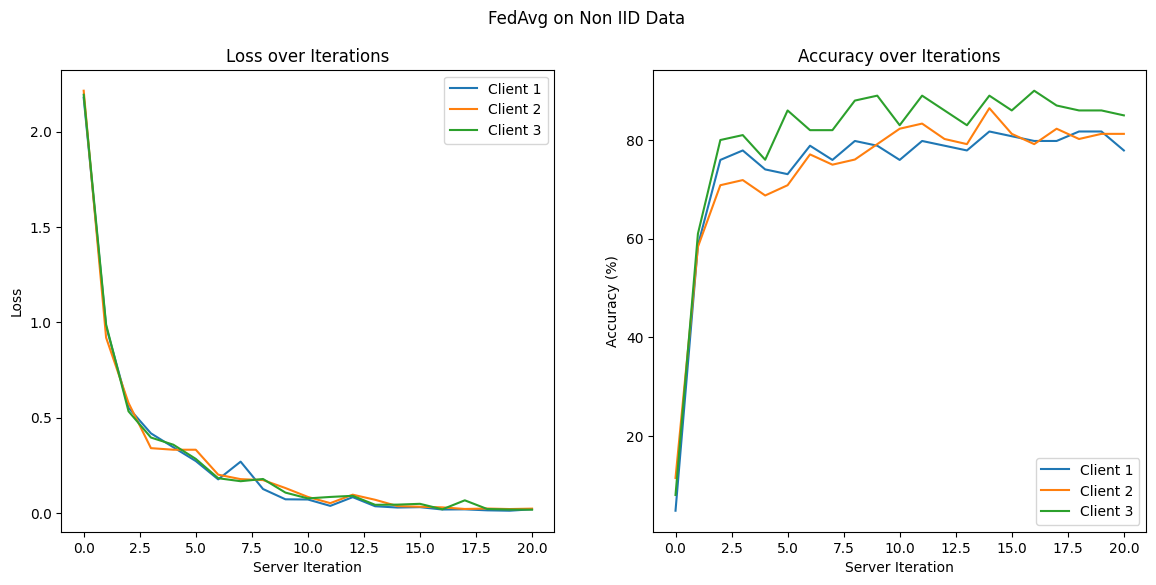

In [ ]:
plot_acc_loss("FedAvg on Non IID Data", loss_hist, acc_hist)

In [ ]:
final_model_p, loss_hist_p, acc_hist_p = FedProx(
    model=model,
    training_sets=blood_mnist_noniid_train,
    n_iter=10,
    testing_sets=blood_mnist_noniid_test,
    mu=0.3,
    epochs=2,
    lr=0.1
)

Clients' weights: [0.3383333333333333, 0.315, 0.3466666666666667]
====> i: 0 Loss: 2.2377705510457355 Server Test Accuracy: 10.610160256410257
====> i: 1 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 2 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 3 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 4 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 5 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 6 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 7 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 8 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 9 Loss: nan Server Test Accuracy: 6.3714903846153845
====> i: 10 Loss: nan Server Test Accuracy: 6.3714903846153845


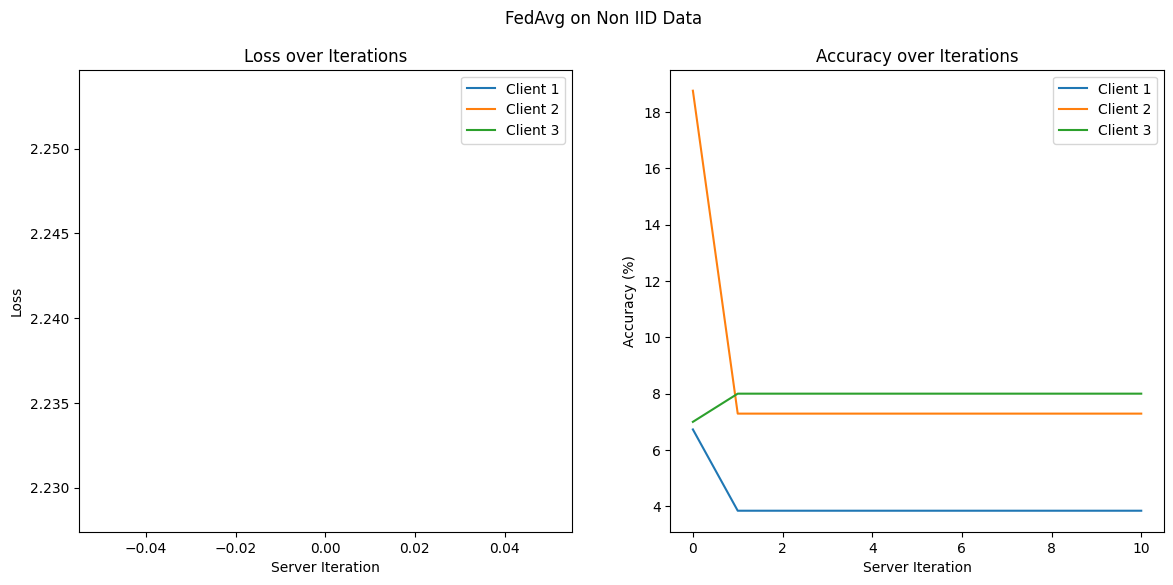

In [ ]:
plot_acc_loss("FedAvg on Non IID Data", loss_hist_p, acc_hist_p)

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf